In [1]:
import sys
import os

# Add particle_detection to sys.path
sys.path.append(os.path.abspath(".."))

In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
from sklearn.mixture import GaussianMixture

from particle_detection.data.data_pipeline import create_dataloaders
from particle_detection.autoencoder.model import create_autoencoder
from particle_detection.utils.model_utils import load_model
from particle_detection.clustering.cluster_visualization import process_and_visualize_clusters, visualize_binary_clusters, compare_original_and_clusters
from particle_detection.utils.pca_preprocessing import apply_pca, plot_explained_variance

In [3]:
data_dir = "../data"
#data_dir = "/home/blah-buttery/nanoparticles/images/normal" # gpu ws 
#dataset_dir = "/Users/blah_m4/Desktop/nanoparticle/images" # macbook
image_size = (2048, 2048)
batch_size = 8

train_loader, test_loader = create_dataloaders(data_dir=data_dir, image_size=image_size, batch_size=batch_size)

In [4]:
model_path = "../saved_models/ae_1000_epochs.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

autoencoder = create_autoencoder().to(device)
autoencoder = load_model(autoencoder, model_path, device=device)
autoencoder.eval()

print("Model loaded successfully.")

Loading model from: ../saved_models/ae_1000_epochs.pth
Model loaded successfully from ../saved_models/ae_1000_epochs.pth.
Model loaded successfully.


In [5]:
# get the latent space by passing dataset through encoder
sample_img = next(iter(test_loader))
sample_img = sample_img.to(device)

with torch.no_grad():
    latent_space = autoencoder.encoder(sample_img)
    print(f"Shape of latent space: {latent_space.shape}")

Shape of latent space: torch.Size([3, 512, 128, 128])


In [6]:
latent_space_reshaped = latent_space.permute(0, 2, 3, 1).reshape(-1, latent_space.shape[1])  # Shape: [N, C]
print(f"Shape of reshaped latent space: {latent_space_reshaped.shape}")

Shape of reshaped latent space: torch.Size([49152, 512])


In [8]:
# apply initial gmm clustering
gmm = GaussianMixture(n_components=5, random_state=42, covariance_type="full")
gmm.fit(latent_space_reshaped.cpu().numpy())
cluster_labels = gmm.predict(latent_space_reshaped.cpu().numpy())

In [9]:
# Map Cluster Labels Back to Spatial Grid
grid_cols = latent_space.shape[3]  # 1024 / 8 = 128
grid_rows = latent_space.shape[2]  # 1024 / 8 = 128
cluster_labels_grid = cluster_labels.reshape(latent_space.shape[0], grid_rows, grid_cols)  # Shape: [B, H, W

print(f"Cluster labels shape: {cluster_labels.shape}")
print(f"Cluster labels grid shape: {cluster_labels_grid.shape}")

Cluster labels shape: (49152,)
Cluster labels grid shape: (3, 128, 128)


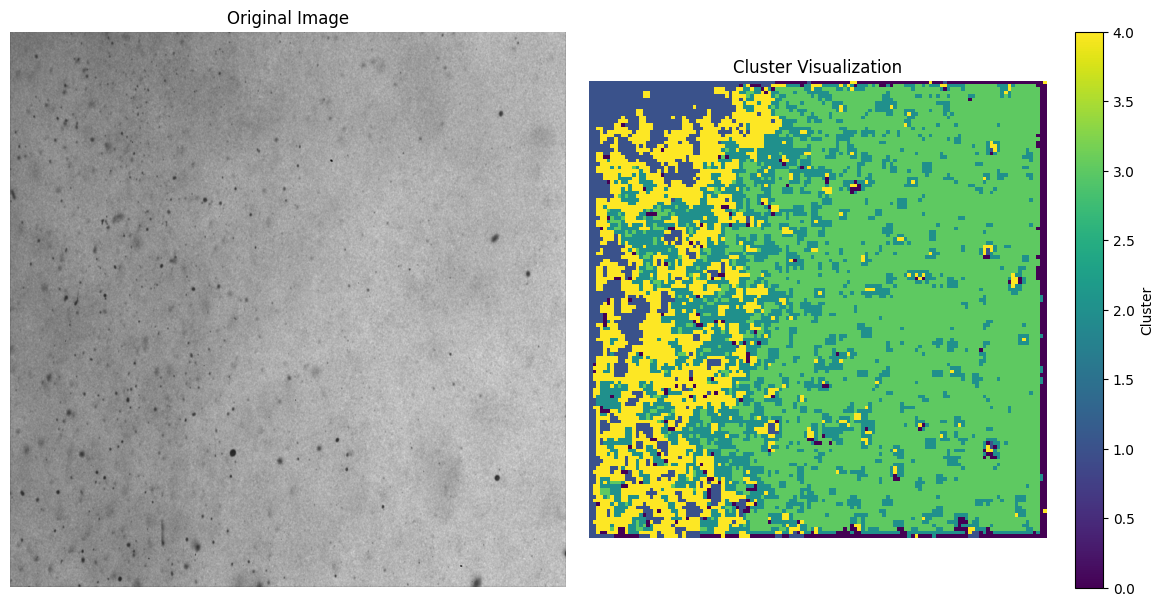

In [10]:
compare_original_and_clusters(sample_img, cluster_labels_grid)

Unique cluster labels: [0 1 2 3 4]


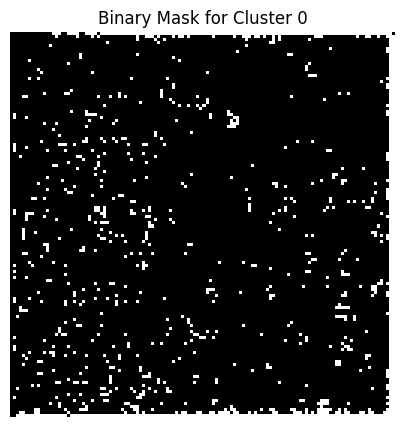

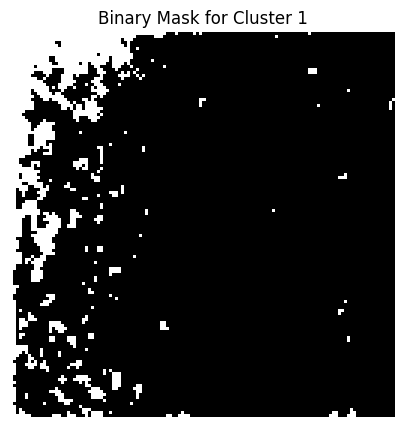

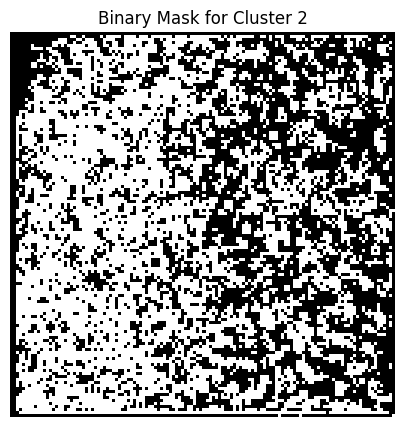

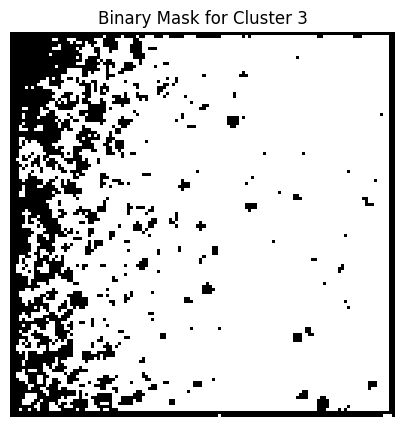

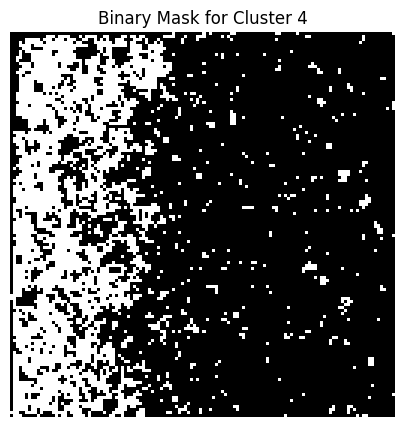

In [11]:
visualize_binary_clusters(cluster_labels_grid)

In [12]:
latent_space_np = latent_space_reshaped.cpu().numpy()
latent_space_pca, pca = apply_pca(latent_space_np, n_components=50)
print(f"Shape after PCA: {latent_space_pca.shape}")

Shape after PCA: (49152, 29)


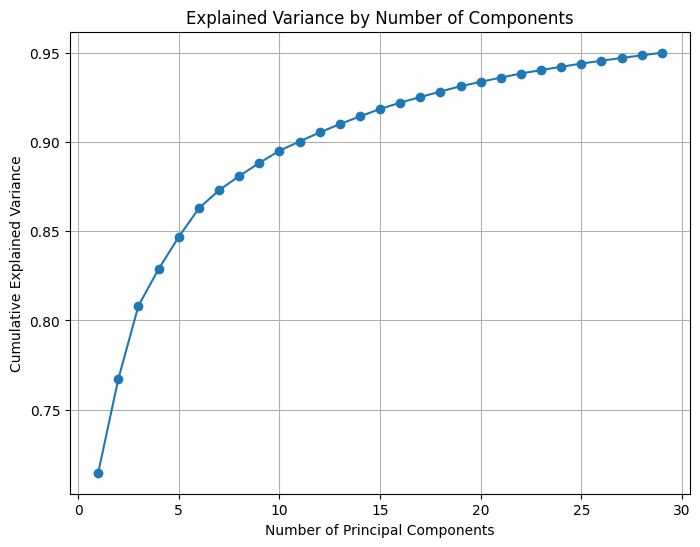

In [13]:
plot_explained_variance(pca)

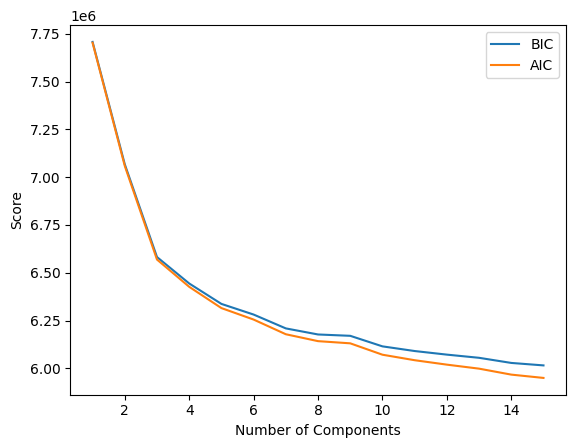

In [16]:
n_components_range = range(1, 16)
bic = []
aic = []

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(latent_space_pca)
    bic.append(gmm.bic(latent_space_pca))
    aic.append(gmm.aic(latent_space_pca))

plt.plot(n_components_range, bic, label="BIC")
plt.plot(n_components_range, aic, label="AIC")
plt.xlabel("Number of Components")
plt.ylabel("Score")
plt.legend()
plt.show()


In [14]:
gmm = GaussianMixture(n_components=3, random_state=42, covariance_type="full")
gmm.fit(latent_space_pca)
cluster_labels = gmm.predict(latent_space_pca)

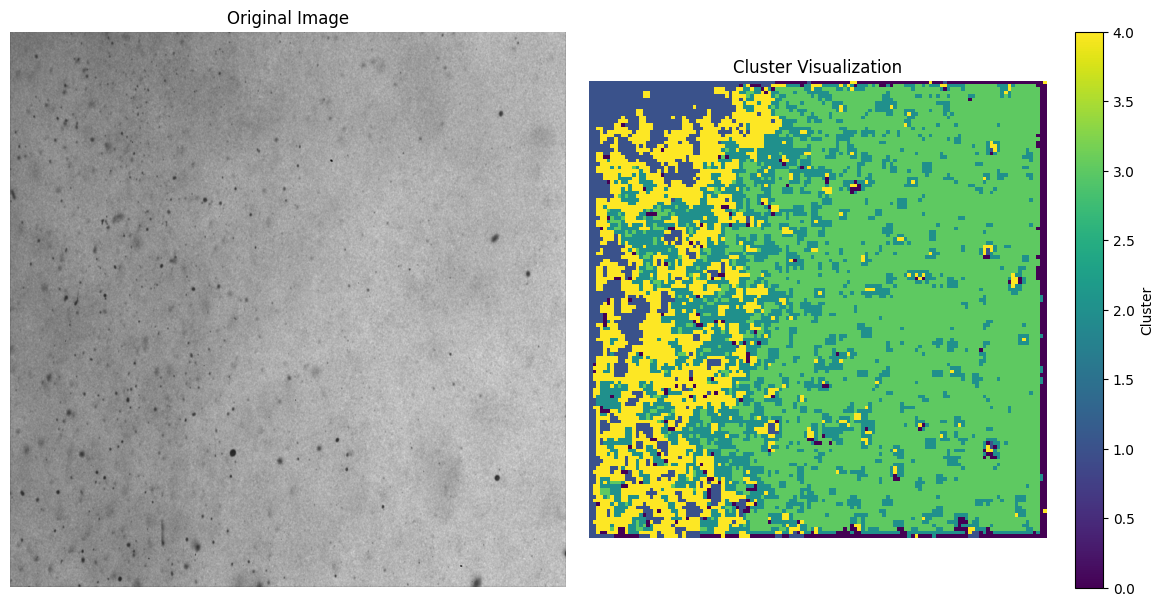

In [15]:
compare_original_and_clusters(sample_img, cluster_labels_grid)

Unique cluster labels: [0 1 2 3 4]


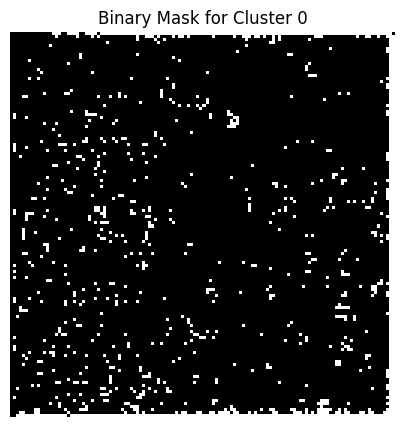

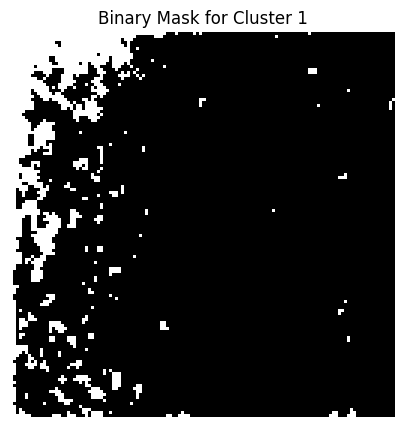

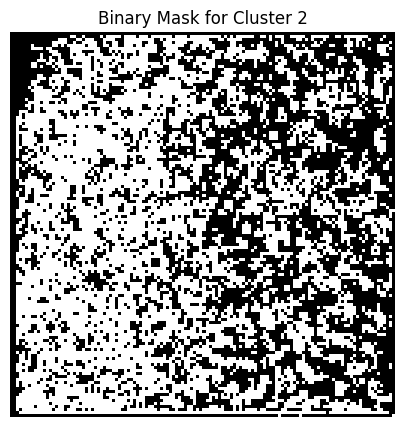

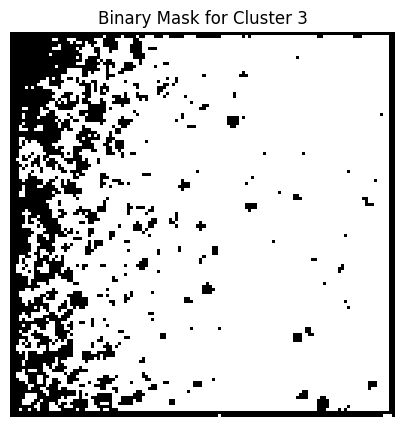

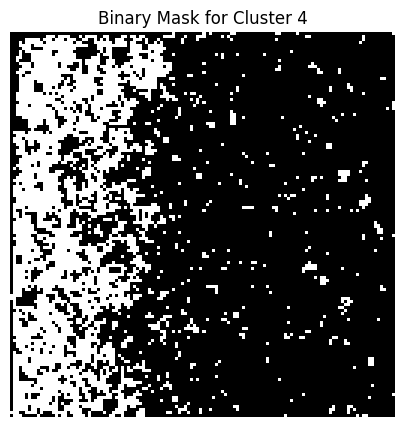

In [16]:
visualize_binary_clusters(cluster_labels_grid)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


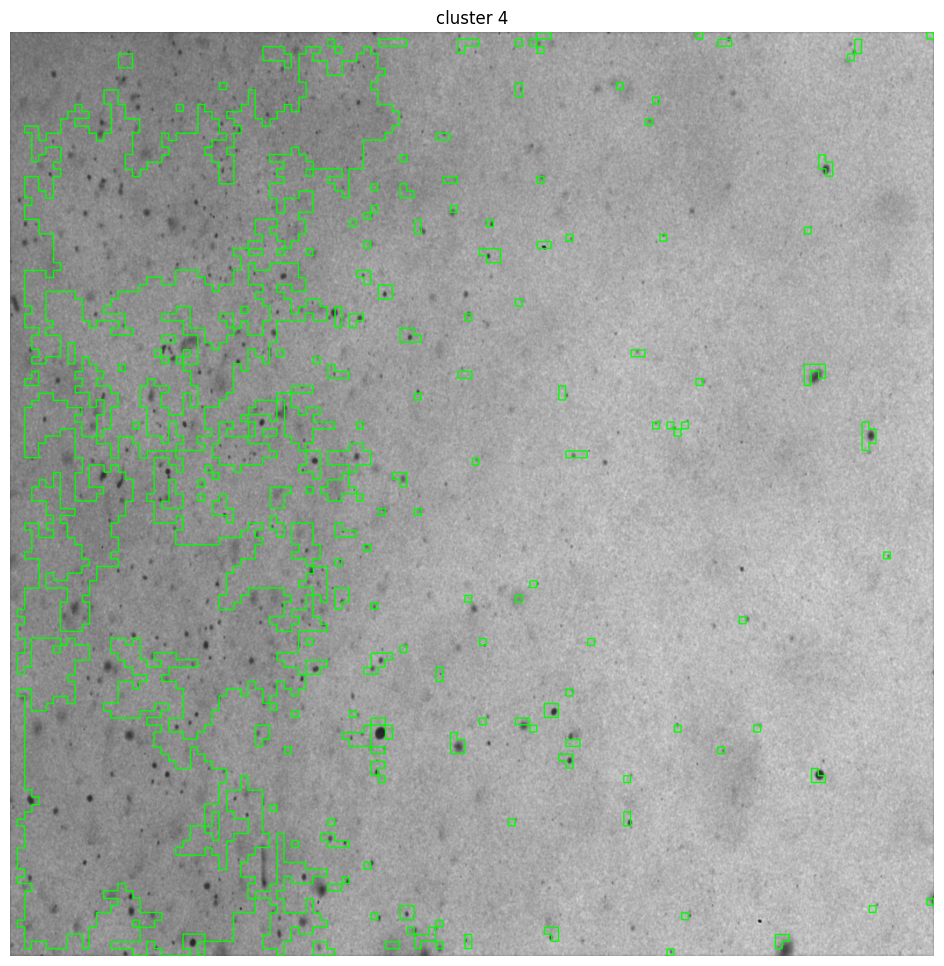

In [22]:
#find the best individual cluster results
process_and_visualize_clusters(sample_img, cluster_labels_grid, cluster_id=4, no_filter=True, title="cluster 4")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


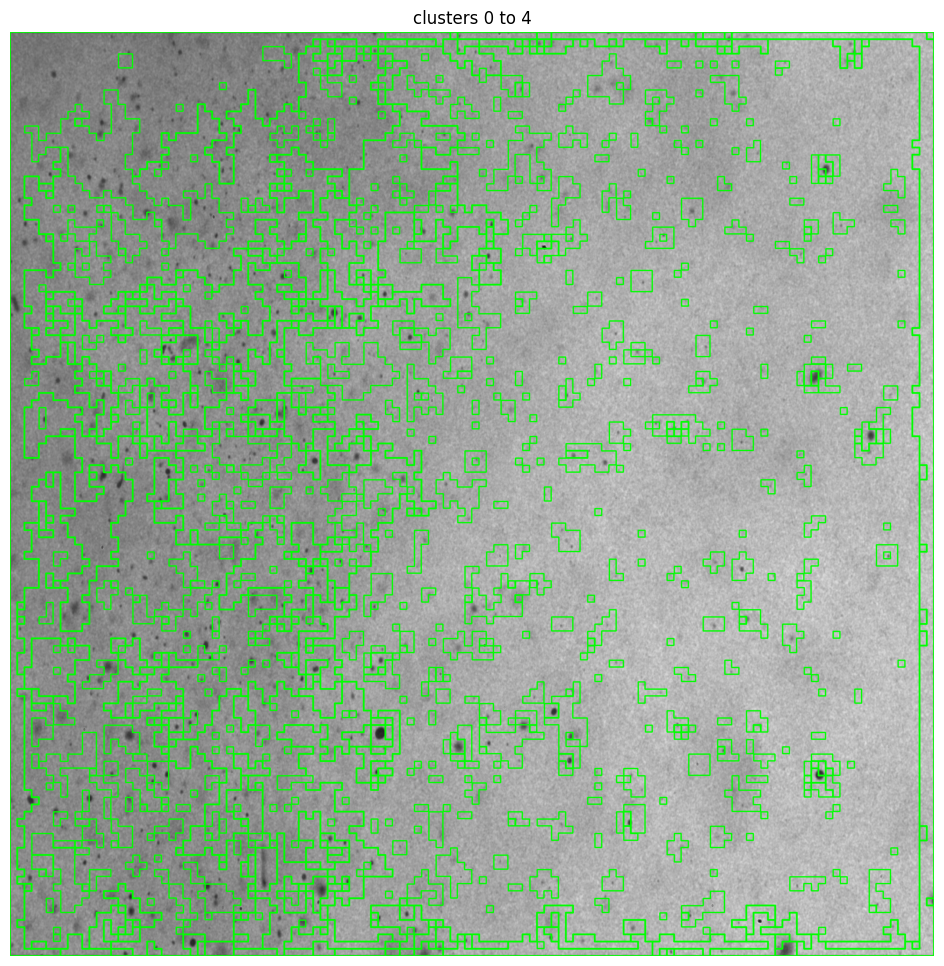

In [23]:
process_and_visualize_clusters(sample_img, cluster_labels_grid, cluster_id=None, no_filter=True, title="clusters 0 to 4")